# Setup

In [1]:
!pip install linearmodels
!pip install nlopt
!pip install -U scikit-learn

# Data Cleaning and Integration

In [2]:
# Import necessary libraries for data manipulation, statistical analysis, and machine learning
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from linearmodels.panel import PanelOLS
import nlopt

# Import libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets from CSV files
eurostoxx_original = pd.read_csv("eurostoxx.csv", low_memory=False)
eurostoxx_isin = pd.read_csv("eurostoxx_ISINs.csv")
trucost = pd.read_csv("07062024_Cushon_Trucost_Data.csv")
isin_summary = pd.read_csv("isin_summary.csv", low_memory=False)
index_price = pd.read_csv("EuroSTOXX600 Historical Price Data.csv")
eurostoxx_sectors = pd.read_csv("Euro Stoxx 600 Data.csv")
carbon_price = pd.read_csv("European Union Allowance (EUA) Yearly Futures Historical Data.csv")
marketCap_missing = pd.read_excel("MarketCapData Missing Companies.xlsx")

# Data cleaning and preprocessing

# For eurostoxx_original dataset
eurostoxx_original.columns = ['Date'] + list(eurostoxx_original.columns[1:])  # Rename the columns
eurostoxx_original = eurostoxx_original.drop(index=0)  # Drop the first row
eurostoxx_original = eurostoxx_original.melt(id_vars=['Date'], var_name='Ticker', value_name='Price')  # Transform wide data to long format
eurostoxx_original['Price'] = pd.to_numeric(eurostoxx_original['Price'], errors='coerce')  # Convert price to numeric
eurostoxx_original['Date'] = pd.to_datetime(eurostoxx_original['Date'])  # Convert date to datetime format

# For isin_summary dataset
isin_summary.columns = ['ISIN'] + list(isin_summary.columns[1:])  # Rename the columns

# For marketCap_missing dataset
marketCap_missing.columns = ['ISIN', 'marketCap']  # Rename the columns

# For index_price dataset
index_price['Date'] = pd.to_datetime(index_price['Date'], format='%d/%m/%Y')  # Convert date to datetime format
index_price['Eurostoxx600_perc'] = index_price['Change %'].str.replace('%', '').astype(float)  # Remove '%' and convert to numeric

# For carbon_price dataset
carbon_price['Date'] = pd.to_datetime(carbon_price['Date'], format='%d/%m/%Y')  # Convert date to datetime format
carbon_price['CarbonPrice_perc'] = carbon_price['Change %'].str.replace('%', '').astype(float)  # Remove '%' and convert to numeric
carbon_price['Vol._k'] = carbon_price['Vol.'].str.replace('K', '').astype(float)  # Remove 'K' and convert to numeric

# List of sectors within the scope of EU ETS (Emission Trading System)
sectors_in_scope = ['Metals & Mining', 'Construction Materials', 'Oil, Gas & Consumable Fuels', 'Electric Utilities', 'Chemicals', 'Independent Power and Renewabl', 'Passenger Airlines', 'Paper & Forest Products']

# Filter companies that are in scope of EU ETS based on sectors
filtered_companies = eurostoxx_sectors[eurostoxx_sectors['GICS 3'].isin(sectors_in_scope)]['ISIN']

# Merge market capitalization data from different sources
marketCap_part = isin_summary[['ISIN', 'marketCap']]
marketCap_part = marketCap_part[marketCap_part['ISIN'].isin(eurostoxx_isin['ISIN'])].dropna()
marketCap = pd.concat([marketCap_missing, marketCap_part], ignore_index=True)

# Merge eurostoxx_original with eurostoxx_isin on 'Ticker' column
eurostoxx = pd.merge(eurostoxx_original, eurostoxx_isin, on='Ticker', how='inner').drop(columns='Ticker')

# Merge eurostoxx with eurostoxx_sectors to add sector information
eurostoxx = eurostoxx.merge(eurostoxx_sectors[['ISIN', 'GICS 3']], on='ISIN', how='left').rename(columns={'GICS 3': 'Sector'})

# Create a new column 'LaggedYear' which is the year before the current date for each entry
eurostoxx['LaggedYear'] = eurostoxx['Date'].dt.year - 1

# Calculate daily return percentage
eurostoxx['Return_perc'] = eurostoxx.groupby('ISIN')['Price'].pct_change() * 100

# Merge eurostoxx with trucost (emission data) on 'ISIN' and 'LaggedYear'
d = pd.merge(eurostoxx, trucost, left_on=['ISIN', 'LaggedYear'], right_on=['ISIN', 'FISCAL_YEAR'], how='left')

# Merge the resulting dataframe with index_price to include market changes in the regression analysis
d = pd.merge(d, index_price[['Date', 'Eurostoxx600_perc']], on='Date', how='left')

# Merge the resulting dataframe with carbon_price and drop unnecessary columns
d = pd.merge(d, carbon_price[['Date', 'CarbonPrice_perc']], on='Date', how='left').drop(columns=['COMPANY_NAME', 'FISCAL_YEAR', 'LaggedYear'])

# Add lagged carbon price data for the previous day
for lag in range(1, 2):
    d[f'CarbonPrice_perc_lagged_{lag}d'] = d['CarbonPrice_perc'].shift(lag)

# Merge the resulting dataframe with market capitalization data
d = pd.merge(d, marketCap, on='ISIN', how='left')

# Drop rows with missing values
d = d.dropna()

# Create a new column to indicate if a company is within the EU ETS scope (1 for in-scope, 0 for out-of-scope)
d['in-scope'] = np.where(d['ISIN'].isin(filtered_companies), 1, 0)

# Descriptive Statistics

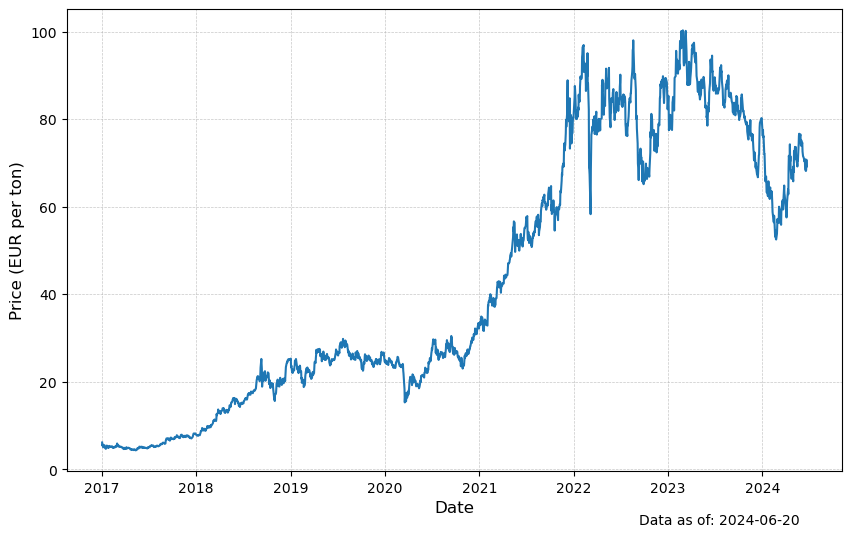

In [3]:
# Figure 1 in dissertation
# Get the latest date from the data
last_date = carbon_price['Date'].max()

# Create a figure for the plot with a specific size
plt.figure(figsize=(10, 6))

# Plot the data with Date on the x-axis and Price on the y-axis, and label the line as 'Price'
plt.plot(carbon_price['Date'], carbon_price['Price'], label='Price')

# Set the label for the x-axis with a font size of 12
plt.xlabel('Date', fontsize=12)

# Set the label for the y-axis with a font size of 12
plt.ylabel('Price (EUR per ton)', fontsize=12)

# Add a light grid with dashed lines, a specific line width, and some transparency
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Add an annotation for the data cut-off date, position it in the bottom right corner,
# adjust the annotation position slightly, and set the font size to 10
plt.annotate(f'Data as of: {last_date.strftime("%Y-%m-%d")}', 
             xy=(1, 0), xycoords='axes fraction',
             horizontalalignment='right', verticalalignment='top', 
             xytext=(-30, -30), textcoords='offset points', fontsize=10)

# Display the plot
plt.show()

In [4]:
# Select specific columns for descriptive statistics, grouped by the 'in-scope' column
specific_stats = d.groupby('in-scope')[['Return_perc', 'CARBON_SCOPE_1', 'CARBON_INTENSITY_SCOPE_1_USD', 
                                        'CARBON_SCOPE_2', 'CARBON_INTENSITY_SCOPE_2_USD', 
                                        'CARBON_SCOPE_3_UPSTREAM', 'CARBON_SCOPE_3_UPSTREAM_INTENSITY_USD', 
                                        'CARBON_SCOPE_3_DOWNSTREAM', 'CARBON_INTENSITY_SCOPE_3_DOWNSTREAM_USD']].describe()

# Print descriptive statistics for specific columns, grouped by 'in-scope'
print(specific_stats['Return_perc'])
print(specific_stats['CARBON_SCOPE_1'])
print(specific_stats['CARBON_INTENSITY_SCOPE_1_USD'])
print(specific_stats['CARBON_SCOPE_2'])
print(specific_stats['CARBON_INTENSITY_SCOPE_2_USD'])
print(specific_stats['CARBON_SCOPE_3_UPSTREAM'])
print(specific_stats['CARBON_SCOPE_3_UPSTREAM_INTENSITY_USD'])
print(specific_stats['CARBON_SCOPE_3_DOWNSTREAM'])
print(specific_stats['CARBON_INTENSITY_SCOPE_3_DOWNSTREAM_USD'])

             count      mean       std        min       25%       50%  \
in-scope                                                                
0         746659.0  0.032067  2.087019 -71.637565 -0.908796  0.021552   
1         116206.0  0.026287  2.106593 -28.265107 -0.987889  0.000000   

               75%        max  
in-scope                       
0         0.987306  89.583333  
1         1.053019  35.561314  
             count          mean           std       min          25%  \
in-scope                                                                
0         746659.0  5.502603e+05  3.439844e+06     0.000    4960.0496   
1         116206.0  1.541009e+07  2.814187e+07  1599.803  456989.2970   

                  50%           75%           max  
in-scope                                           
0           24399.021  1.410523e+05  8.923643e+07  
1         3099426.636  1.710797e+07  1.815336e+08  
             count        mean          std    min        25%         50%  \
i

# Regression Analysis

In [5]:
# OLS model function
def ols_model(df, carbon_price_column, scope):
    # Create a copy of the dataframe to avoid modifying the original data
    df_copy = df.copy()
    
    # Apply log(x + 1) transformation to specified columns to handle skewness
    df_copy['CARBON_INTENSITY_SCOPE_1_USD'] = np.log1p(df_copy['CARBON_INTENSITY_SCOPE_1_USD'])
    df_copy['CARBON_INTENSITY_SCOPE_2_USD'] = np.log1p(df_copy['CARBON_INTENSITY_SCOPE_2_USD'])

    # Generate interaction terms using PolynomialFeatures
    interaction = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    interaction_terms = interaction.fit_transform(df_copy[[carbon_price_column, 'CARBON_INTENSITY_SCOPE_1_USD', 'CARBON_INTENSITY_SCOPE_2_USD']])
    interaction_feature_names = interaction.get_feature_names_out([carbon_price_column, 'CARBON_INTENSITY_SCOPE_1_USD', 'CARBON_INTENSITY_SCOPE_2_USD'])
    
    # List of features that are not needed
    unwanted_features = ['CARBON_INTENSITY_SCOPE_1_USD CARBON_INTENSITY_SCOPE_2_USD', 'CARBON_INTENSITY_SCOPE_1_USD', 'CARBON_INTENSITY_SCOPE_2_USD']
    filtered_features = [feat for feat in interaction_feature_names if feat not in unwanted_features]
    
    # Add the filtered interaction terms to the dataframe
    interaction_df = pd.DataFrame(interaction_terms, columns=interaction_feature_names, index=df_copy.index)
    interaction_df = interaction_df[filtered_features]
    df_copy = df_copy.join(interaction_df, rsuffix='_interaction')

    # Filter the dataframe based on the 'scope' parameter (in-scope, out-of-scope, or whole dataset)
    if scope == 'in':
        df_copy = df_copy[df_copy['in-scope'] == 1]
    elif scope == 'out':
        df_copy = df_copy[df_copy['in-scope'] == 0]
    elif scope == 'whole':
        pass  # No filtering is needed for the whole dataset
    else:
        raise ValueError("Invalid scope value. Use 'in', 'out', or 'whole'.")

    # Create the formula for the OLS model, including the interaction terms
    interaction_terms_formula = ' + '.join([f'Q("{col}")' for col in filtered_features])
    formula = f'Return_perc ~ 1 + Eurostoxx600_perc  + {interaction_terms_formula}'

    # Fit the OLS model using the formula and the filtered data
    model = smf.ols(formula, data=df_copy)
    return model.fit()  # Return the fitted model results

In [6]:
# Fixed effects model function
def fixed_effects(df, carbon_price_column, scope):
    # Create a copy of the dataframe to avoid modifying the original data
    df_copy = df.copy()
    
    # Apply log(x + 1) transformation to specified columns to handle skewness
    df_copy['CARBON_INTENSITY_SCOPE_1_USD'] = np.log1p(df_copy['CARBON_INTENSITY_SCOPE_1_USD'])
    df_copy['CARBON_INTENSITY_SCOPE_2_USD'] = np.log1p(df_copy['CARBON_INTENSITY_SCOPE_2_USD'])
    
    # Define columns that will be used to create interaction terms
    interaction_columns = [carbon_price_column, 'CARBON_INTENSITY_SCOPE_1_USD', 'CARBON_INTENSITY_SCOPE_2_USD']
    
    # Create interaction terms using PolynomialFeatures
    interaction = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    interaction_terms = interaction.fit_transform(df_copy[interaction_columns])
    interaction_feature_names = interaction.get_feature_names_out(interaction_columns)
    
    # Add interaction terms to the dataframe, avoiding overlap with existing columns
    interaction_df = pd.DataFrame(interaction_terms, columns=interaction_feature_names, index=df_copy.index)
    df_copy = df_copy.join(interaction_df, rsuffix='_interaction')
    
    # Filter the dataframe based on the 'scope' parameter (in-scope, out-of-scope, or whole dataset)
    if scope == 'in':
        df_copy = df_copy[df_copy['in-scope'] == 1]
    elif scope == 'out':
        df_copy = df_copy[df_copy['in-scope'] == 0]
    elif scope == 'whole':
        pass  # No filtering is needed for the whole dataset
    else:
        raise ValueError("Invalid scope value. Use 'in', 'out', or 'whole'.")
    
    # Drop rows with missing values to ensure the model can be fitted properly
    df_copy = df_copy.dropna()
    
    # Set the index for panel data to identify entities (ISIN) and time periods (Date)
    df_copy.set_index(['ISIN', 'Date'], inplace=True)
    
    # Correctly format interaction terms for the formula, excluding unwanted features
    unwanted_features = ['CARBON_INTENSITY_SCOPE_1_USD', 'CARBON_INTENSITY_SCOPE_2_USD',
                         'CARBON_INTENSITY_SCOPE_1_USD CARBON_INTENSITY_SCOPE_2_USD']
    interaction_terms_formula = ' + '.join([f'`{term}`' for term in interaction_feature_names if term not in unwanted_features])
    
    # Build the formula for the fixed effects model
    formula = f'Return_perc ~ 1 + Eurostoxx600_perc + EntityEffects + {interaction_terms_formula}'
    
    # Define and fit the fixed effects model using the formula and the prepared data
    model = PanelOLS.from_formula(formula, data=df_copy)
    results = model.fit()
    
    return results  # Return the fitted model results


In [7]:
# Obtain OLS model results for in-scope and out-of-scope data
results_in = ols_model(d, 'CarbonPrice_perc', 'in')
results_out = ols_model(d, 'CarbonPrice_perc', 'out')

# Obtain Fixed effects model results for in-scope and out-of-scope data
fixed_results_in = fixed_effects(d, 'CarbonPrice_perc', 'in')
fixed_results_out = fixed_effects(d, 'CarbonPrice_perc', 'out')

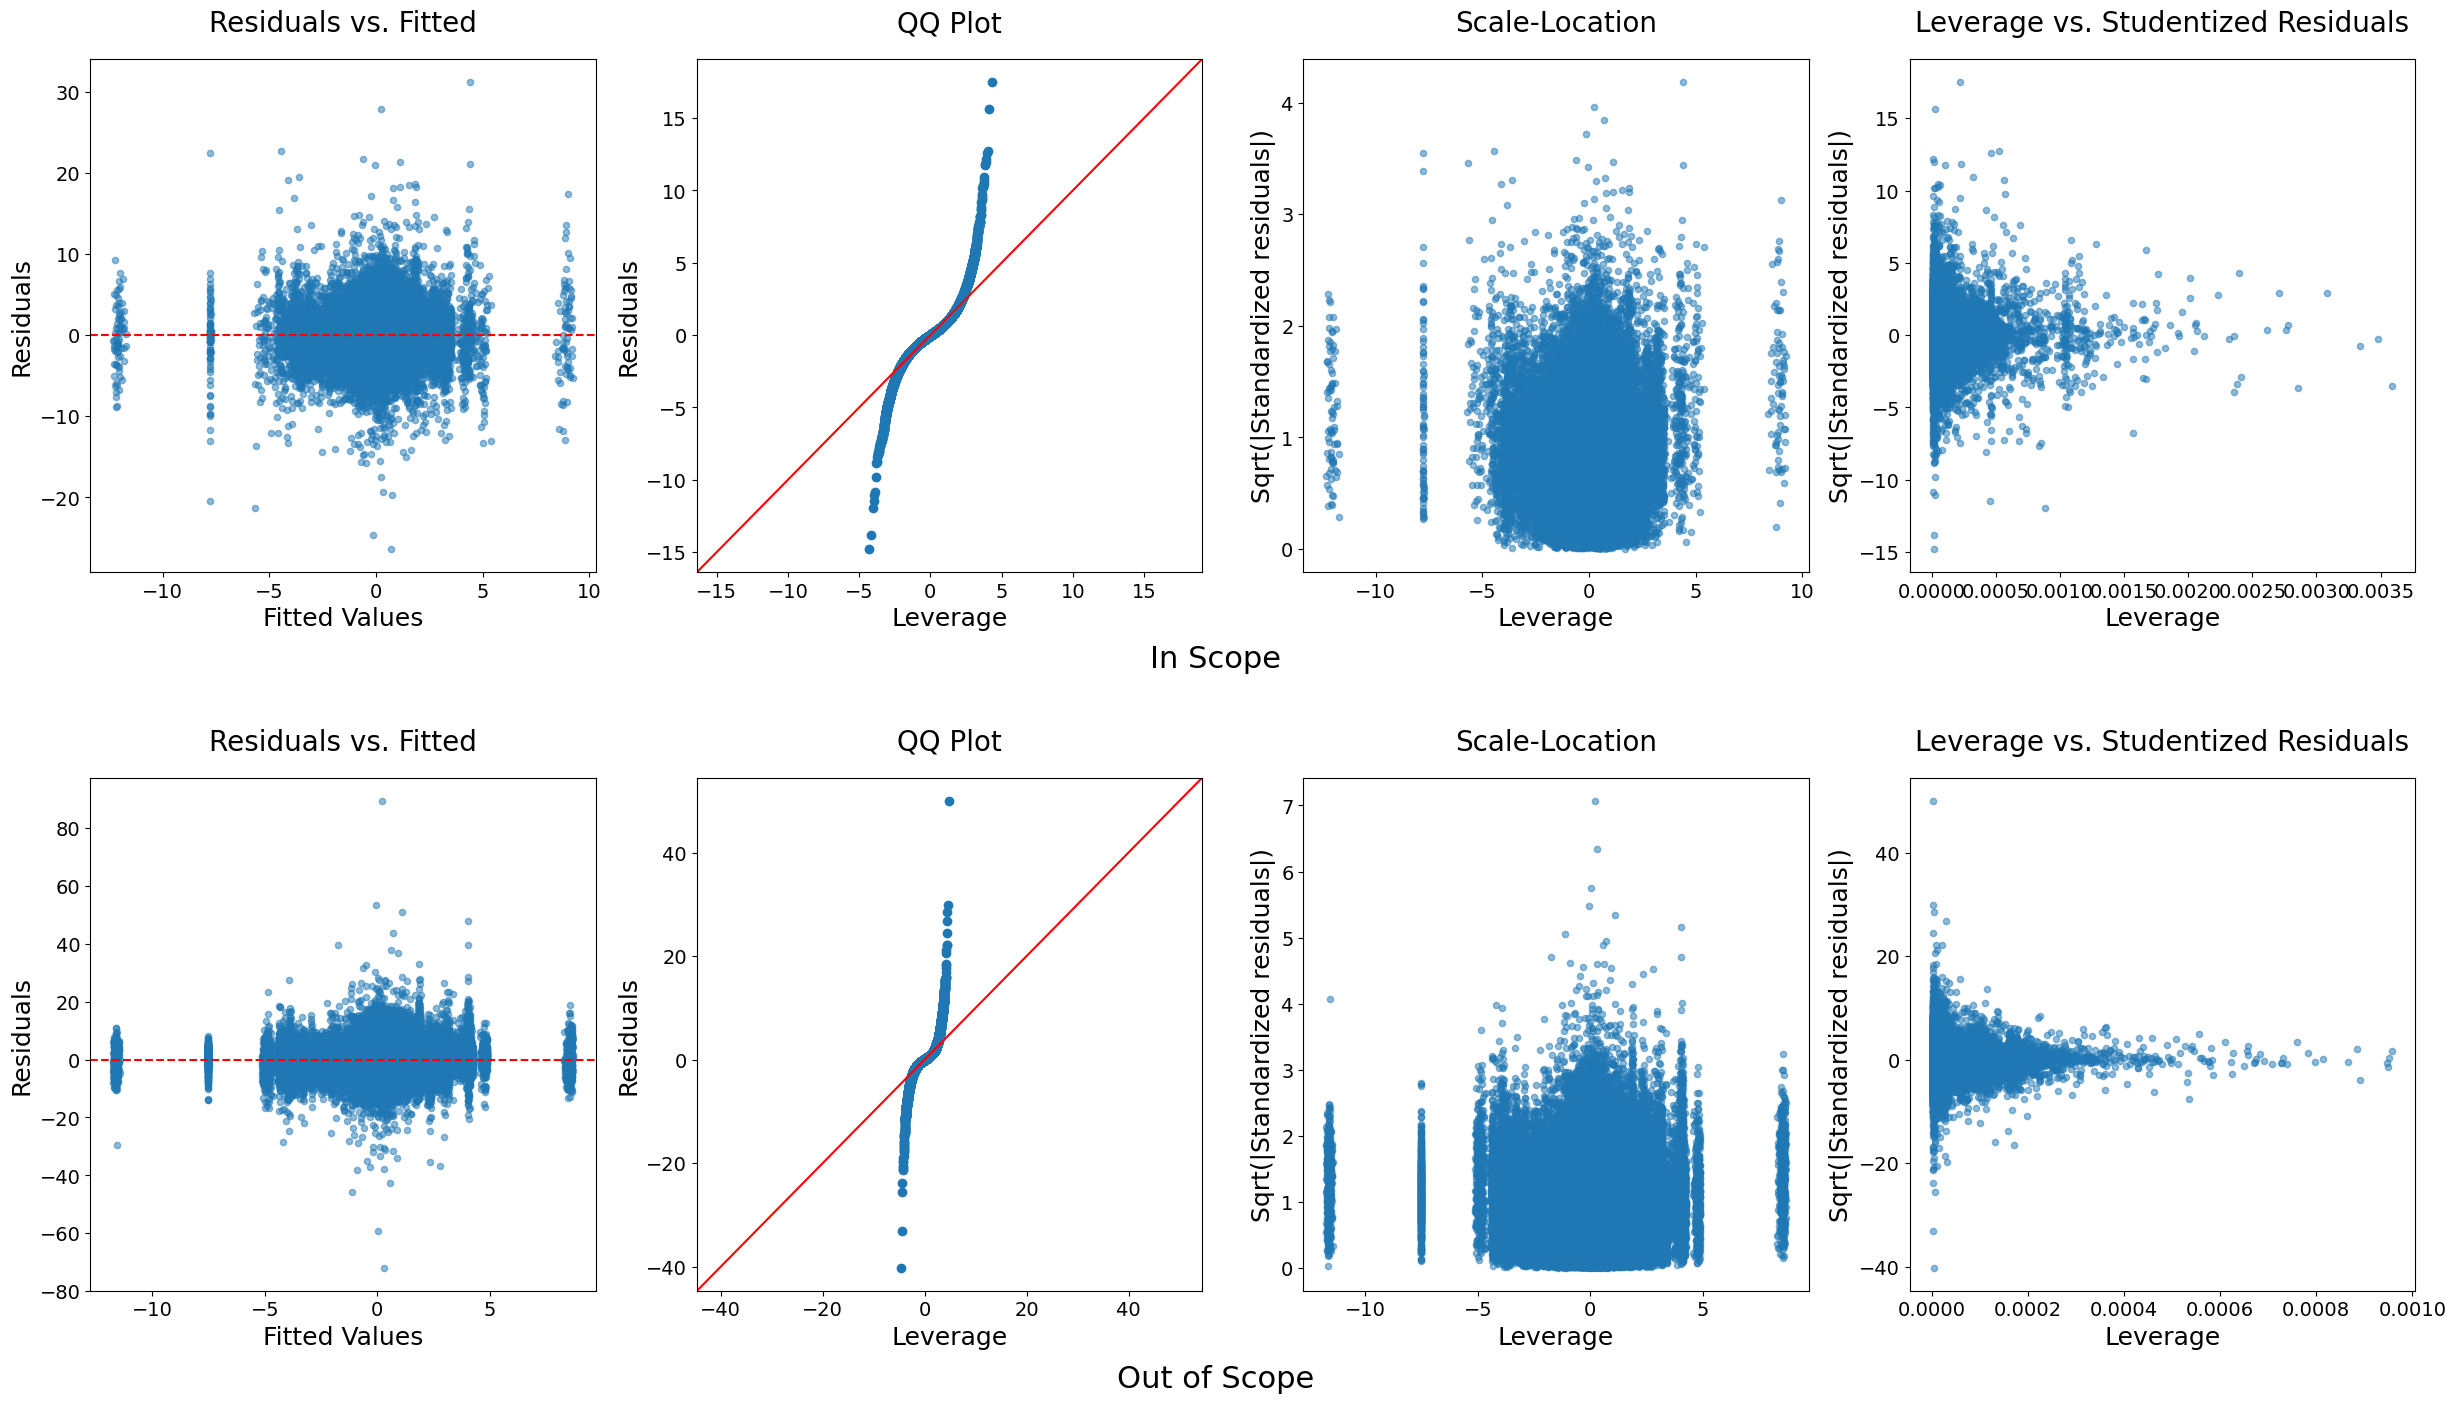

In [8]:
# Diagnostic Tests
# Create a new plotting area with eight subplots (2 rows, 4 columns)
fig, ax = plt.subplots(2, 4, figsize=(30, 16), gridspec_kw={'hspace': 0.4, 'wspace': 0.2})

# Define shared column titles for the plots
column_titles = ['Residuals vs. Fitted', 'QQ Plot', 'Scale-Location', 'Leverage vs. Studentized Residuals']
label_size = 18  # Set the label font size
title_size = 20  # Set the title font size
title_pad = 20   # Increase the distance between the title and the plot
axis_tick_size = 14  # Set the axis tick font size
point_size = 20   # Set the point size for scatter plots
alpha_value = 0.5  # Set the transparency level for points

# General function to set up the plots for each column
def setup_plots(results, row):
    # Calculate leverage and studentized residuals
    influence = results.get_influence()
    leverage = influence.hat_matrix_diag
    studentized_residuals = influence.resid_studentized_internal
    
    # Plot Residuals vs. Fitted values
    ax[row, 0].scatter(results.fittedvalues, results.resid, s=point_size, alpha=alpha_value)
    ax[row, 0].axhline(y=0, color='red', linestyle='dashed')
    
    # QQ plot of residuals
    sm.qqplot(results.resid, line='45', ax=ax[row, 1], fit=True)
    
    # Scale-Location plot (Spread-Location plot)
    ax[row, 2].scatter(results.fittedvalues, np.sqrt(np.abs(studentized_residuals)), alpha=alpha_value, s=point_size)
    
    # Leverage vs. Studentized Residuals plot
    ax[row, 3].scatter(leverage, studentized_residuals, alpha=alpha_value, s=point_size)
    
    # Set axis labels and titles
    for i in range(4):
        ax[row, i].set_xlabel('Fitted Values' if i == 0 else 'Leverage', fontsize=label_size)
        ax[row, i].set_ylabel('Residuals' if i < 2 else 'Sqrt(|Standardized residuals|)', fontsize=label_size)
        ax[row, i].tick_params(axis='both', which='major', labelsize=axis_tick_size)
        ax[row, i].set_title(column_titles[i], fontsize=title_size, pad=title_pad)  # Adjust title spacing

# Set up diagnostic plots for in-scope and out-of-scope data
setup_plots(results_in, 0)
setup_plots(results_out, 1)

# Add row labels at the bottom center of each row, adjusting vertical position
fig.text(0.5, 0.5, 'In Scope', ha='center', fontsize=22)  # Adjust vertical position
fig.text(0.5, 0.05, 'Out of Scope', ha='center', fontsize=22)  # Adjust vertical position

# Display the plots
plt.show()

# Scenario Analysis

In [9]:
# Dictionary mapping sectors to specific colors for visualization
sector_colors = {
    'Metals & Mining': '#d62728',  # red
    'Construction Materials': '#dbdb8d',  # light grey
    'Oil, Gas & Consumable Fuels': '#2ca02c',  # green
    'Electric Utilities': '#1f77b4',  # blue
    'Chemicals': '#17becf',  # cyan
    'Independent Power and Renewabl': '#ff7f0e',  # orange
    'Passenger Airlines': '#c7c7c7',  # silver
    'Paper & Forest Products': '#9edae5',  # light blue
}

In [10]:
# Prediction functions applying np.log1p to carbon intensities as used in the regression model
def calculate_predicted_returns(row, price_increase):
    """ Calculate the predicted returns based on carbon price impacts. """
    log_carbon_intensity_1 = np.log1p(row['CARBON_INTENSITY_SCOPE_1_USD'])
    log_carbon_intensity_2 = np.log1p(row['CARBON_INTENSITY_SCOPE_2_USD'])
    if row['in-scope'] == 1:  # In-scope companies
        beta_cp, beta_cp_int1, beta_cp_int2 = -0.0393, 0.0141, -0.0060
    else:  # Out-of-scope companies
        beta_cp, beta_cp_int1, beta_cp_int2 = 0.0191, -0.0032, -0.0050
    return (beta_cp * price_increase +
            beta_cp_int1 * price_increase * log_carbon_intensity_1 +
            beta_cp_int2 * price_increase * log_carbon_intensity_2)

def calculate_predicted_prices(df, price_increase):
    """ Calculate predicted prices based on predicted returns. """
    df['Predicted_Return_%'] = df.apply(lambda row: calculate_predicted_returns(row, price_increase), axis=1)
    df['Predicted_Price_Impact'] = df['Price'] * (1 + (df['Predicted_Return_%'] / 100))
    return df

## Forward Analysis

In [11]:
# Data preprocessing
# for d
yearly_d = d.assign(Year=d['Date'].dt.year).groupby(['ISIN', 'Year']).agg({
    'Price': 'mean',
    'CARBON_INTENSITY_SCOPE_1_USD': 'mean',
    'CARBON_INTENSITY_SCOPE_2_USD': 'mean',
    'marketCap': 'mean',
    'in-scope': 'mean',
    'Sector': 'last'
}).reset_index()

# for carbon_price
yearly_carbon_price = carbon_price.assign(Year=carbon_price['Date'].dt.year).groupby(['Year']).agg({
    'Price': 'mean'
}).rename(columns={'Price': 'CarbonPrice'}).reset_index()

# Merging data
yearly_df = pd.merge(yearly_d, yearly_carbon_price, on=['Year'], how='inner')

# Calculating intial weights
yearly_df['initial_weight'] = yearly_df['marketCap'] / yearly_df.groupby('Year')['marketCap'].transform('sum')
yearly_df['initial_weight'] /= yearly_df.groupby('Year')['initial_weight'].transform('sum')

In [12]:
def scenario_analysis_yearly(year, price_increase_percent):
    # Filter the data for the given year
    df_filtered = yearly_df[yearly_df['Year'] == year].copy()

    # Calculate predicted prices directly
    df_updated = calculate_predicted_prices(df_filtered.copy(), price_increase_percent)

    # Objective function
    def objective_function(weights, grad):
        if grad.size > 0:
            grad[:] = 2 * (weights - df_updated['initial_weight'].values)
        return np.sum((weights - df_updated['initial_weight'].values) ** 2)

    # Constraint: Sum of weights must equal 1
    def constraint_sum_weights(weights, grad):
        if grad.size > 0:
            grad[:] = np.ones_like(weights)
        return np.sum(weights) - 1

    # Constraint: Ensure portfolio's predicted value is at least 80% of its current value
    def constraint_predicted_value(weights, grad):
        predicted_value = np.dot(weights, df_updated['Predicted_Price_Impact'].values)
        actual_value = np.dot(df_filtered['initial_weight'].values, df_filtered['Price'].values)
        if grad.size > 0:
            grad[:] = df_updated['Predicted_Price_Impact'].values
        return predicted_value - 0.8 * actual_value

    # Create an optimizer object
    opt = nlopt.opt(nlopt.LD_SLSQP, len(df_filtered['initial_weight'].values))
    opt.set_min_objective(objective_function)
    opt.add_equality_constraint(constraint_sum_weights, 1e-8)
    opt.add_inequality_constraint(constraint_predicted_value, 1e-8)
    opt.set_lower_bounds(0.0)
    opt.set_upper_bounds(1.0)
    opt.set_xtol_rel(1e-6)

    # Perform optimization
    try:
        optimized_weights = opt.optimize(df_filtered['initial_weight'].values)
        minimized_value = opt.last_optimum_value()
    except Exception as e:
        print(f"Optimization failed: {e}")
        return None

    # Calculate weights by scope
    df_filtered['Optimized Weights'] = optimized_weights
    scope_weights = df_filtered.groupby('in-scope')['Optimized Weights'].sum()

    # Ensure the correct mapping of the scope weights
    in_scope_weight_sum = scope_weights.get(1.0, 0)
    out_of_scope_weight_sum = scope_weights.get(0.0, 0)

    # Analyze sector contributions within in-scope and out-of-scope
    in_scope_sector_weights = df_filtered[df_filtered['in-scope'] == 1.0].groupby('Sector')['Optimized Weights'].sum()
    out_of_scope_sector_weights = df_filtered[df_filtered['in-scope'] == 0.0].groupby('Sector')['Optimized Weights'].sum()

    # Identify companies with zero weights after optimization
    zero_weight_indices = np.where(optimized_weights == 0)[0]
    zero_weight_companies = df_filtered.iloc[zero_weight_indices]

    # Calculate the proportion of in-scope companies in the original data and among zero-weight companies
    in_scope_proportion = df_filtered['in-scope'].mean()
    zero_weight_in_scope_proportion = zero_weight_companies['in-scope'].mean()

    # Output detailed results for analysis
    return {
        'Optimized Weights': optimized_weights,
        'Objective Function Value': minimized_value,
        'In-Scope Weight Sum': in_scope_weight_sum,
        'Out-of-Scope Weight Sum': out_of_scope_weight_sum,
        'In-Scope Sector Weights': in_scope_sector_weights,
        'Out-of-Scope Sector Weights': out_of_scope_sector_weights,
        'Zero Weight Companies': zero_weight_companies,
        'Proportion of In-Scope Companies in Data': in_scope_proportion,
        'Proportion of In-Scope Companies in Zero Weight Companies': zero_weight_in_scope_proportion
    }

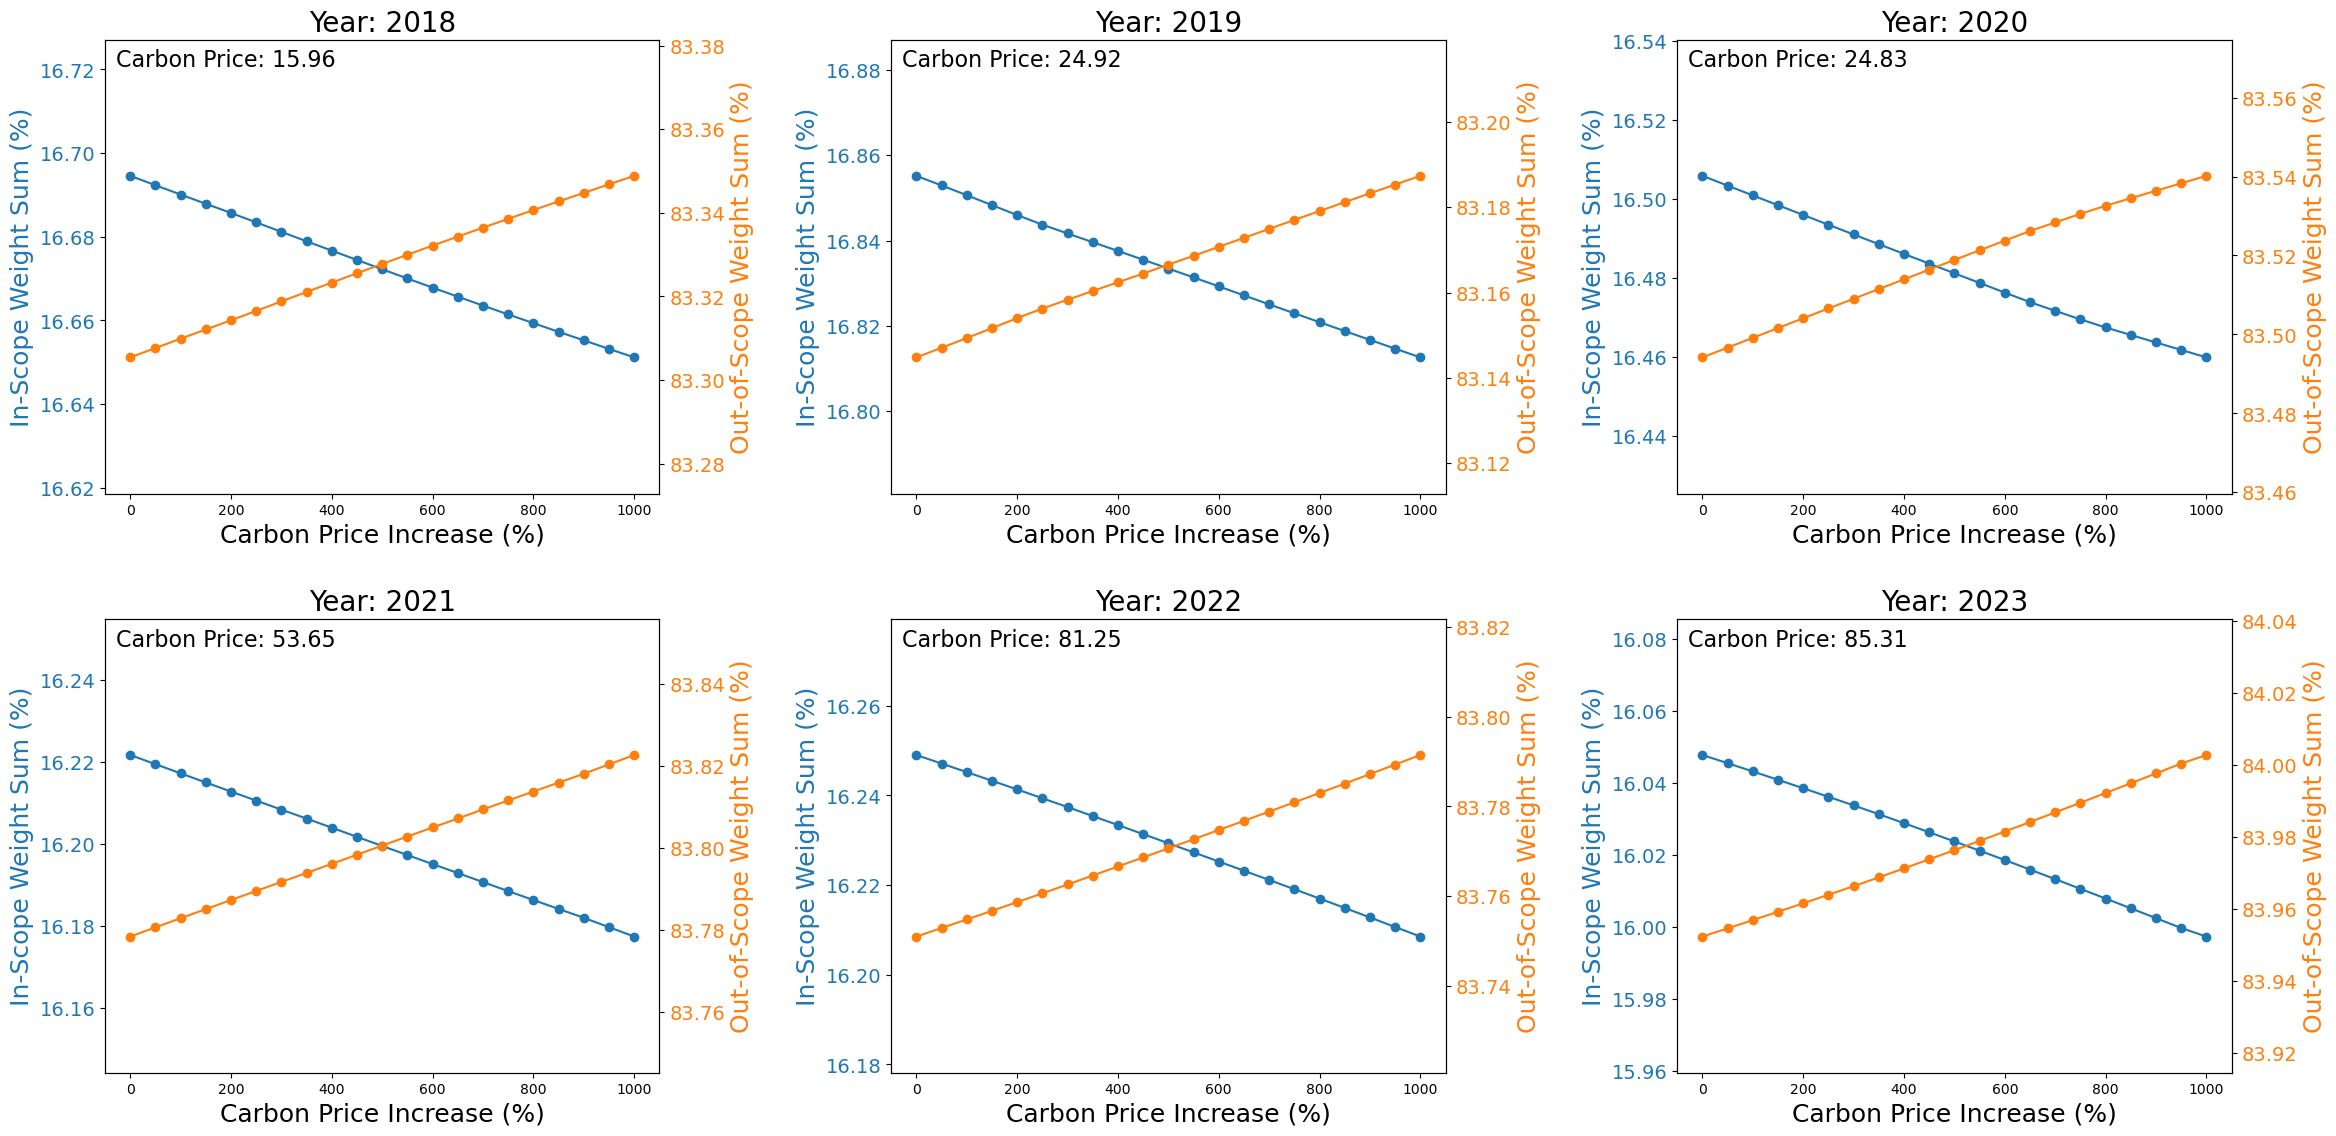

In [13]:
# Figure represents the impact of carbon price increases on the in-scope weight and out-of-scope weight
# Define the years and carbon price increase parameters
years = range(2018, 2024)  # Years from 2018 to 2023
price_increases = np.arange(0, 1001, 50)  # 0% to 1000% by 50% increments

# Initialize the plotting with 2 rows and 3 columns (total 6 plots)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 12))  # 6 plots arranged in 2 rows and 3 columns
axes = axes.flatten()  # Flatten the grid of subplots into a 1D array for easier indexing

# Iterate through each year to plot
for index, year in enumerate(years):
    in_scope_weights = []
    out_of_scope_weights = []
    
    # Generate data for each carbon price increase
    for increase in price_increases:
        results = scenario_analysis_yearly(year, increase)
        in_scope_weights.append(results['In-Scope Weight Sum'] * 100)
        out_of_scope_weights.append(results['Out-of-Scope Weight Sum'] * 100)
    
    ax1 = axes[index]
    
    # Plot in-scope weights on the left y-axis
    ax1.set_xlabel('Carbon Price Increase (%)', fontsize=18)
    ax1.set_ylabel('In-Scope Weight Sum (%)', color='tab:blue', fontsize=18)
    ax1.plot(price_increases, in_scope_weights, color='tab:blue', marker='o', label='In-Scope Weight Sum')
    ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)  # Increase the size of Y-axis labels
    
    # Adjust the y-axis range to make the changes less exaggerated
    in_scope_range = max(in_scope_weights) - min(in_scope_weights)
    ax1.set_ylim([min(in_scope_weights) - in_scope_range * 0.75, max(in_scope_weights) + in_scope_range * 0.75])

    # Create a second y-axis for out-of-scope weights
    ax2 = ax1.twinx()  
    ax2.set_ylabel('Out-of-Scope Weight Sum (%)', color='tab:orange', fontsize=18)
    ax2.plot(price_increases, out_of_scope_weights, color='tab:orange', marker='o', label='Out-of-Scope Weight Sum')
    ax2.tick_params(axis='y', labelcolor='tab:orange', labelsize=14)  # Increase the size of Y-axis labels
    
    # Adjust the y-axis range to make the changes less exaggerated
    out_of_scope_range = max(out_of_scope_weights) - min(out_of_scope_weights)
    ax2.set_ylim([min(out_of_scope_weights) - out_of_scope_range * 0.75, max(out_of_scope_weights) + out_of_scope_range * 0.75])
    
    # Add the carbon price text on the upper left of each subplot
    current_price = yearly_df[yearly_df['Year'] == year]['CarbonPrice'].unique()[0]  # Get current carbon price
    ax1.text(0.02, 0.98, f'Carbon Price: {current_price:.2f}', transform=ax1.transAxes,
             verticalalignment='top', horizontalalignment='left', fontsize=16, color='black')

    ax1.set_title(f'Year: {year}', fontsize=20)

# Adjust layout to avoid overlap and add padding between subplots
plt.tight_layout(pad=3.0, w_pad=3.0, h_pad=3.0)
plt.show()

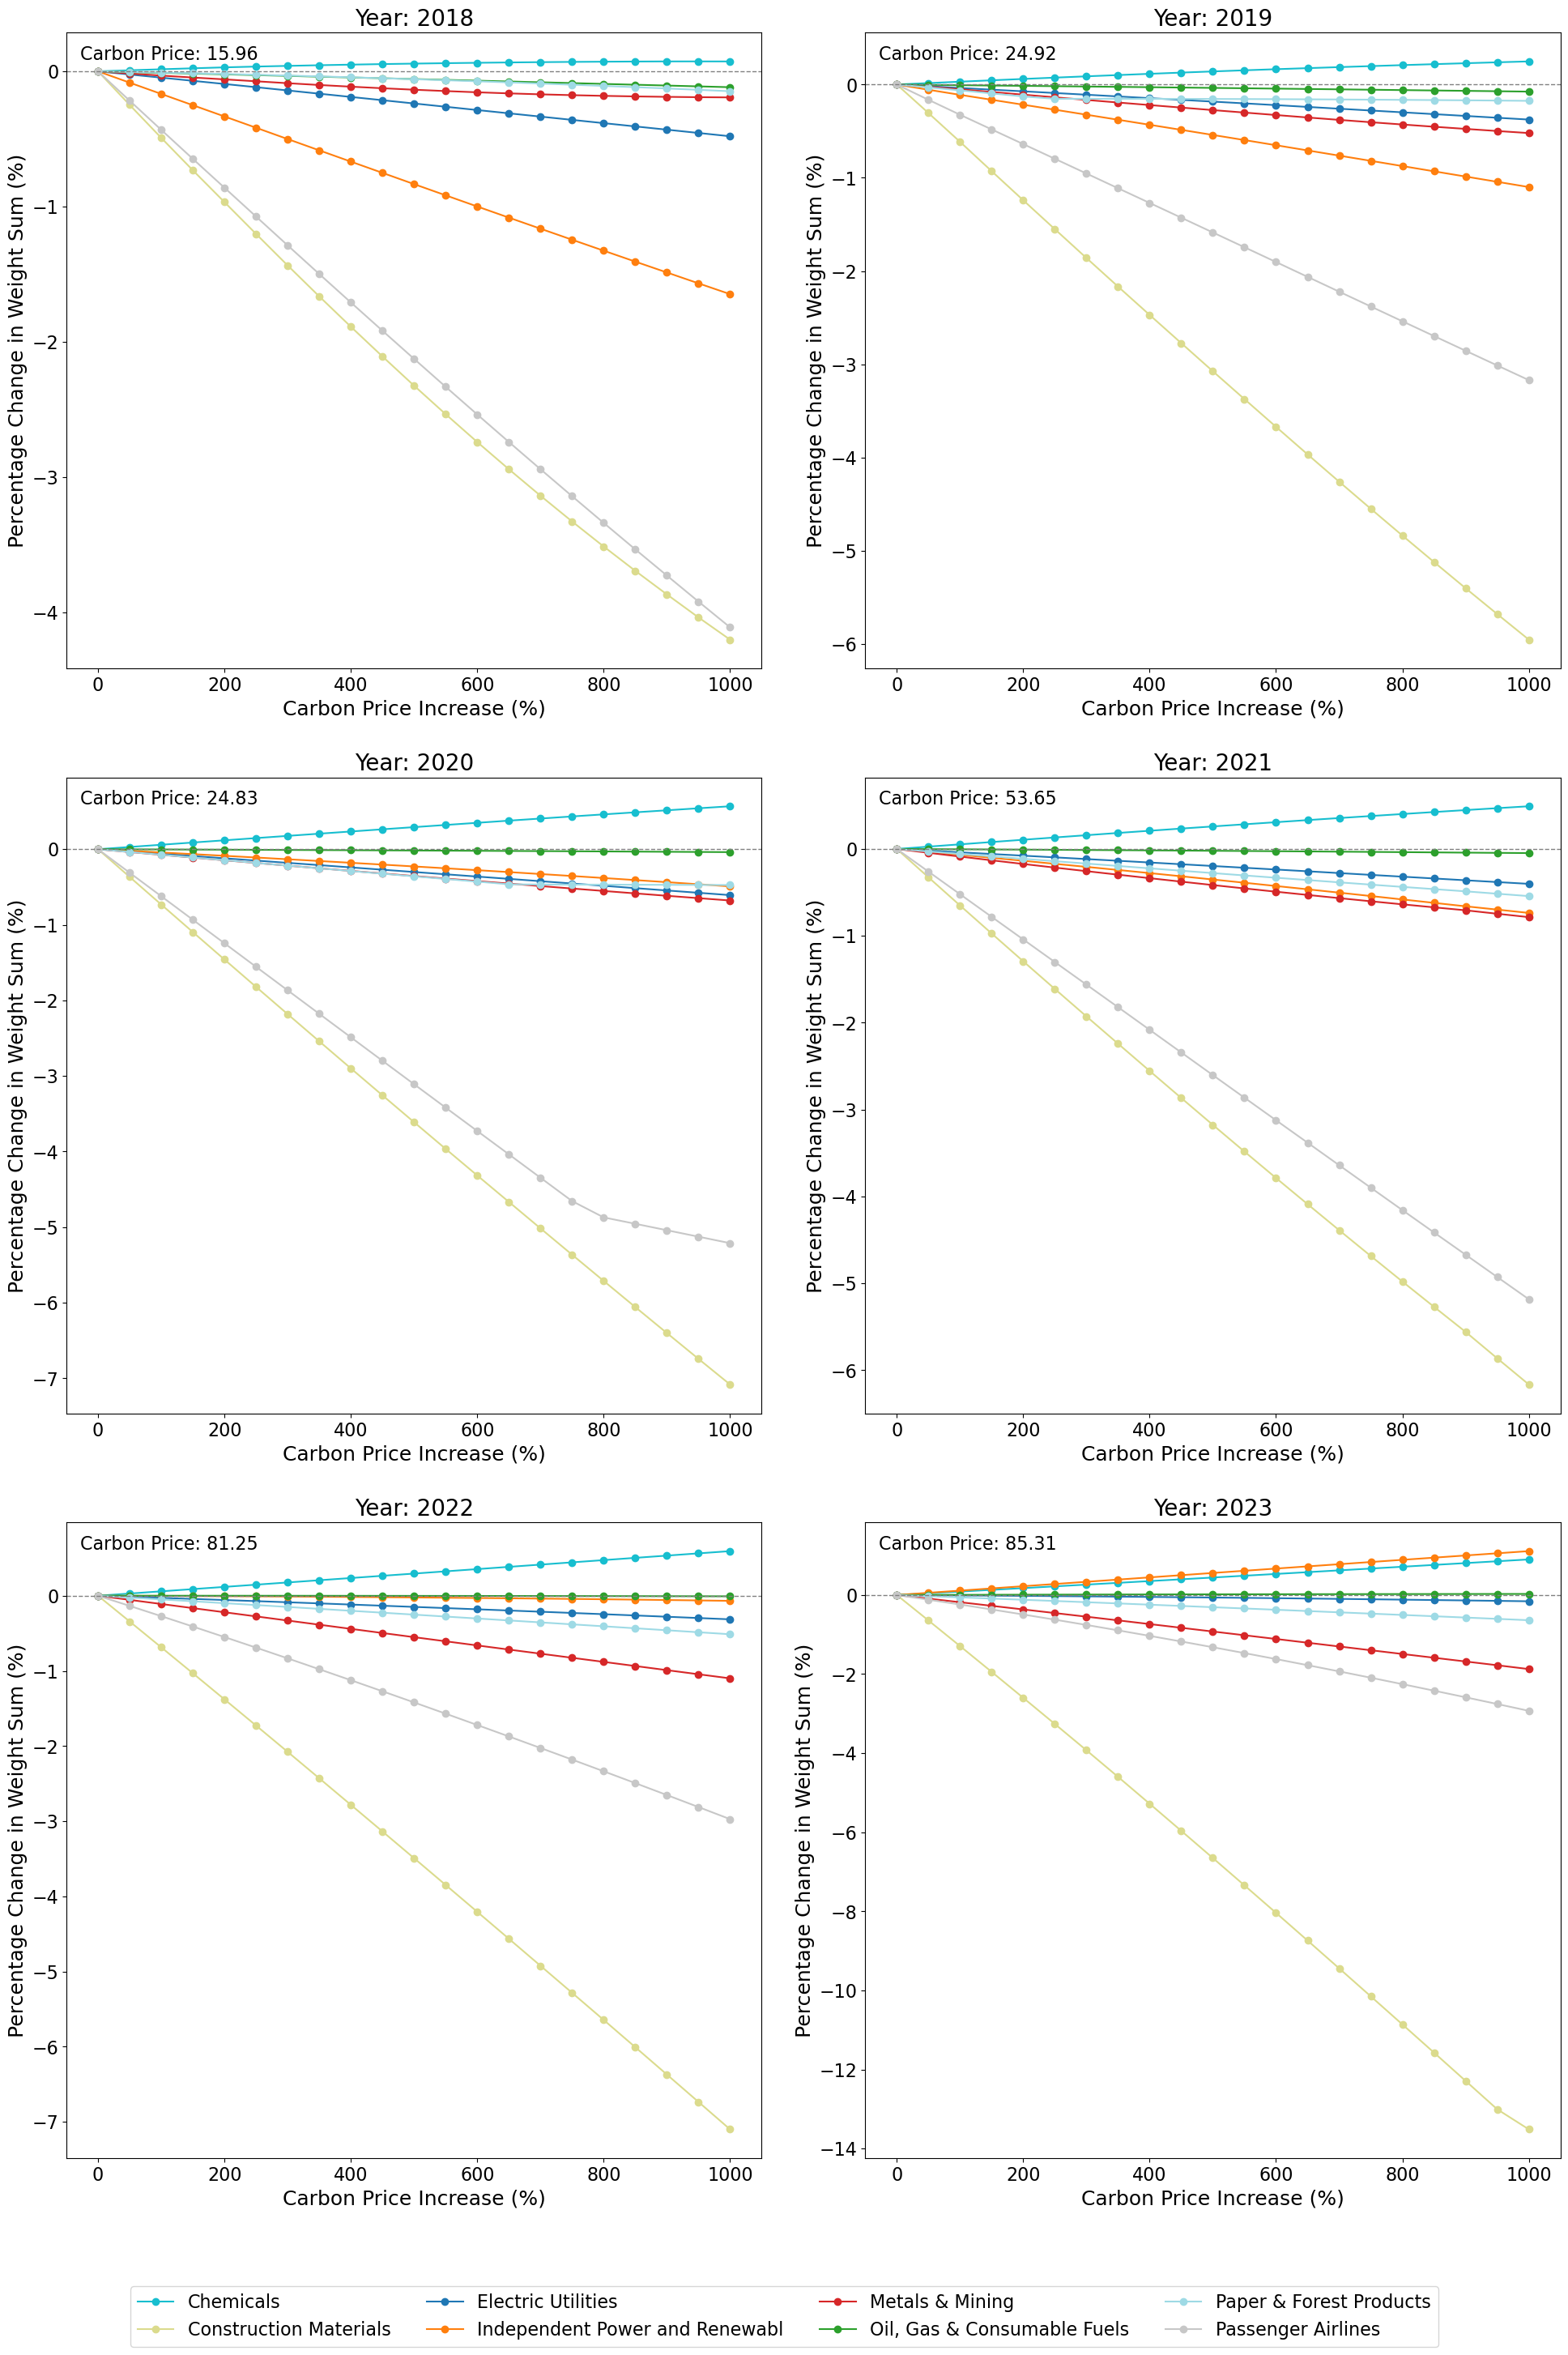

In [14]:
# Figure represents the impact of carbon price increases on the percentage changes in in-scope sectors' weights
# Initialize the plotting
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 28))
axes = axes.flatten()

# Define the years and carbon price increase parameters
years = range(2018, 2024)  # Years from 2018 to 2023
price_increases = np.arange(0, 1001, 50)  # 0% to 1000% by 50% increments

# Iterate through each year to plot
for i, year in enumerate(years):
    sector_trends = {}
    base_weights = {}

    # Initialize a dictionary to store the sector weight sums across different price increases
    for increase in price_increases:
        results = scenario_analysis_yearly(year, increase)
        
        for sector, weight in results['In-Scope Sector Weights'].items():
            if sector not in sector_trends:
                sector_trends[sector] = []
            if increase == 0:
                # Store base weight for percentage calculation
                base_weights[sector] = weight
            # Calculate the percentage change from the base
            percent_change = ((weight - base_weights.get(sector, 0)) / base_weights.get(sector, 0)) * 100
            sector_trends[sector].append(percent_change)

    # Plot the trends for each sector on the assigned subplot
    for sector, weights in sector_trends.items():
        axes[i].plot(price_increases, weights, marker='o', label=sector, color=sector_colors.get(sector, 'black'))
    
    # Set basic parameters of the plot
    axes[i].set_title(f'Year: {year}', fontsize=20)
    axes[i].set_xlabel('Carbon Price Increase (%)', fontsize=18)
    axes[i].set_ylabel('Percentage Change in Weight Sum (%)', fontsize=18)
    axes[i].axhline(y=0, color='grey', linestyle='--', linewidth=1)  # Draw a reference line at 0% change

    # Increase tick label size
    axes[i].tick_params(axis='both', labelsize=16)

    # Add the carbon price text on the upper left of each subplot
    current_price = yearly_df[yearly_df['Year'] == year]['CarbonPrice'].unique()[0]  # Get current carbon price
    axes[i].text(0.02, 0.98, f'Carbon Price: {current_price:.2f}', transform=axes[i].transAxes,
                 verticalalignment='top', horizontalalignment='left', fontsize=16, color='black')

# Set a legend
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05), fontsize=16)

# Adjust layout to provide space between plots
plt.tight_layout(pad=3.0, w_pad=3.0, h_pad=3.0)
plt.show()

# Backward Analysis

In [15]:
# Data preprocessing
# for d
quarterly_d = d.assign(Year=d['Date'].dt.year, Quarter=d['Date'].dt.to_period('Q')).groupby(['ISIN', 'Year', 'Quarter']).agg({
    'Price': 'mean',
    'CARBON_INTENSITY_SCOPE_1_USD': 'mean',
    'CARBON_INTENSITY_SCOPE_2_USD': 'mean',
    'marketCap': 'mean',
    'in-scope': 'mean'
}).reset_index()
quarterly_d['Date'] = quarterly_d['Quarter'].dt.start_time
quarterly_d['Price_Perc'] = quarterly_d['Price'].pct_change() * 100

# for carbon_price
quarterly_carbon_price = carbon_price.assign(Year=carbon_price['Date'].dt.year, Quarter=carbon_price['Date'].dt.to_period('Q')).groupby(['Year', 'Quarter']).agg({
    'Price': 'mean'
}).rename(columns={'Price': 'CarbonPrice'}).reset_index()
quarterly_carbon_price['Date'] = quarterly_carbon_price['Quarter'].dt.start_time
quarterly_carbon_price['CarbonPrice_Perc'] = quarterly_carbon_price['CarbonPrice'].pct_change().shift(-1) * 100

# Merging quarterly data
quarterly_df = pd.merge(quarterly_d, quarterly_carbon_price, on=['Year', 'Quarter', 'Date'], how='inner')

# Calculate the intersection of companies for each year and quarter
quarters = quarterly_df['Quarter'].unique()
intersections = []

for quarter in quarters:
    companies_in_quarter = set(quarterly_df[quarterly_df['Quarter'] == quarter]['ISIN'])
    if not intersections:
        intersections.append(companies_in_quarter)
    else:
        intersections[0] = intersections[0].intersection(companies_in_quarter)

baseline_companies = intersections[0]

# Filter to only include companies in the baseline stock pool
quarterly_df = quarterly_df[quarterly_df['ISIN'].isin(baseline_companies)]

# Calculating initial weights
quarterly_df['initial_weight'] = quarterly_df['marketCap'] / quarterly_df.groupby('Date')['marketCap'].transform('sum')
quarterly_df['initial_weight'] /= quarterly_df.groupby('Date')['initial_weight'].transform('sum')

# Apply calculate_predicted_prices function
for index, row in quarterly_df.iterrows():
    price_increase = row['CarbonPrice_Perc']
    quarterly_df.at[index, 'Predicted_Return_%'] = calculate_predicted_returns(row, price_increase)
    quarterly_df.at[index, 'Predicted_Price_Impact'] = row['Price'] * (1 + quarterly_df.at[index, 'Predicted_Return_%'] / 100)

# Set index to Quarter
quarterly_df.set_index('Quarter', inplace=True)

In [16]:
# Show the number of benchmark stocks
len(baseline_companies)

539

In [17]:
def back_test(protection_perc):
    # Initialize an empty list to store results for each quarter
    results = []

    # Iterate through each quarter, skipping the last quarter because there is no next quarter data
    for quarter in quarterly_df.index.unique()[:-1]:  # Ensure the index is unique quarters
        try:
            current_quarter = quarterly_df.loc[quarter]
        except KeyError:
            print(f"Quarter {quarter} not found in quarterly_df index")
            continue

        # Determine the next quarter's index and data
        next_quarter_index = quarterly_df.index.unique()[quarterly_df.index.unique().get_loc(quarter) + 1]
        next_quarter = quarterly_df.loc[next_quarter_index]

        # Get initial weights for the current quarter and next quarter's prices and initial weights
        initial_weights = current_quarter['initial_weight'].values
        next_initial_weights = next_quarter['initial_weight'].values
        next_quarter_returns = next_quarter['Price_Perc'].values
    
        # Check for matching dimensions between weights and prices arrays
        if len(initial_weights) != len(next_initial_weights):
            print(f"Mismatch in dimensions on {quarter} between weights and prices!")
            results.append({
                'Quarter': quarter,
                'OptimizedValue': np.nan,
                'ActualValue': np.nan
            })
            continue  

        # Define the optimization objective function (minimize the difference between new and initial weights)
        def objective(weights, grad):
            if grad.size > 0:
                grad[:] = 2 * (weights - initial_weights)
            return np.sum((weights - initial_weights) ** 2)

        # Define the equality constraint (weights sum to 1)
        def equality_constraint(weights, grad):
            if grad.size > 0:
                grad[:] = 1
            return np.sum(weights) - 1

        # Define the inequality constraint (expected portfolio value constraint based on protection percentage)
        def inequality_constraint(weights, grad):
            if grad.size > 0:
                grad[:] = current_quarter['Predicted_Price_Impact'].values
            return np.dot(weights, current_quarter['Predicted_Price_Impact'].values) - 0.01 * protection_perc * np.dot(initial_weights, current_quarter['Price'].values)

        # Set up the optimizer using the Sequential Least SQuares Programming (SLSQP) method
        opt = nlopt.opt(nlopt.LD_SLSQP, len(initial_weights))
        opt.set_lower_bounds(0)
        opt.set_upper_bounds(1)
        opt.set_min_objective(objective)
        opt.add_equality_constraint(equality_constraint, 1e-8)
        opt.add_inequality_constraint(inequality_constraint, 1e-8)
        opt.set_xtol_rel(1e-6)
        opt.set_maxeval(10000)  # Increase maximum evaluations to ensure convergence

        # Optimize the weights for the portfolio
        try:
            optimized_weights = opt.optimize(initial_weights)
        except Exception as e:
            print(f"Optimization failed for {quarter}: {e}")
            results.append({
                'Quarter': quarter,
                'OptimizedValue': np.nan,
                'ActualValue': np.nan
            })
            continue

        # Calculate the portfolio's expected (optimized) and actual performance for the next quarter
        optimized_performance = np.dot(optimized_weights, next_quarter_returns)
        actual_performance = np.dot(next_initial_weights, next_quarter_returns)

        # Store the results for the current quarter
        results.append({
            'Quarter': quarter,
            'OptimizedPerformance': optimized_performance,
            'ActualPerformance': actual_performance
        })
        
    # Convert the list of results to a DataFrame
    results_df = pd.DataFrame(results)
        
    # Convert the 'Quarter' column to string format
    results_df['Quarter'] = results_df['Quarter'].astype(str)
        
    return results_df  # Return the results as a DataFrame

In [18]:
# Get the results under 20%, 50%, and 80% protection level
results_80 = back_test(80)
results_50 = back_test(50)
results_20 = back_test(20)

# Calculate cumulative return
results_80['CumulativeActualPerformance'] = results_80['ActualPerformance'].cumsum()
results_80['CumulativeOptimizedPerformance'] = results_80['OptimizedPerformance'].cumsum()
results_50['CumulativeOptimizedPerformance'] = results_50['OptimizedPerformance'].cumsum()
results_20['CumulativeOptimizedPerformance'] = results_20['OptimizedPerformance'].cumsum()

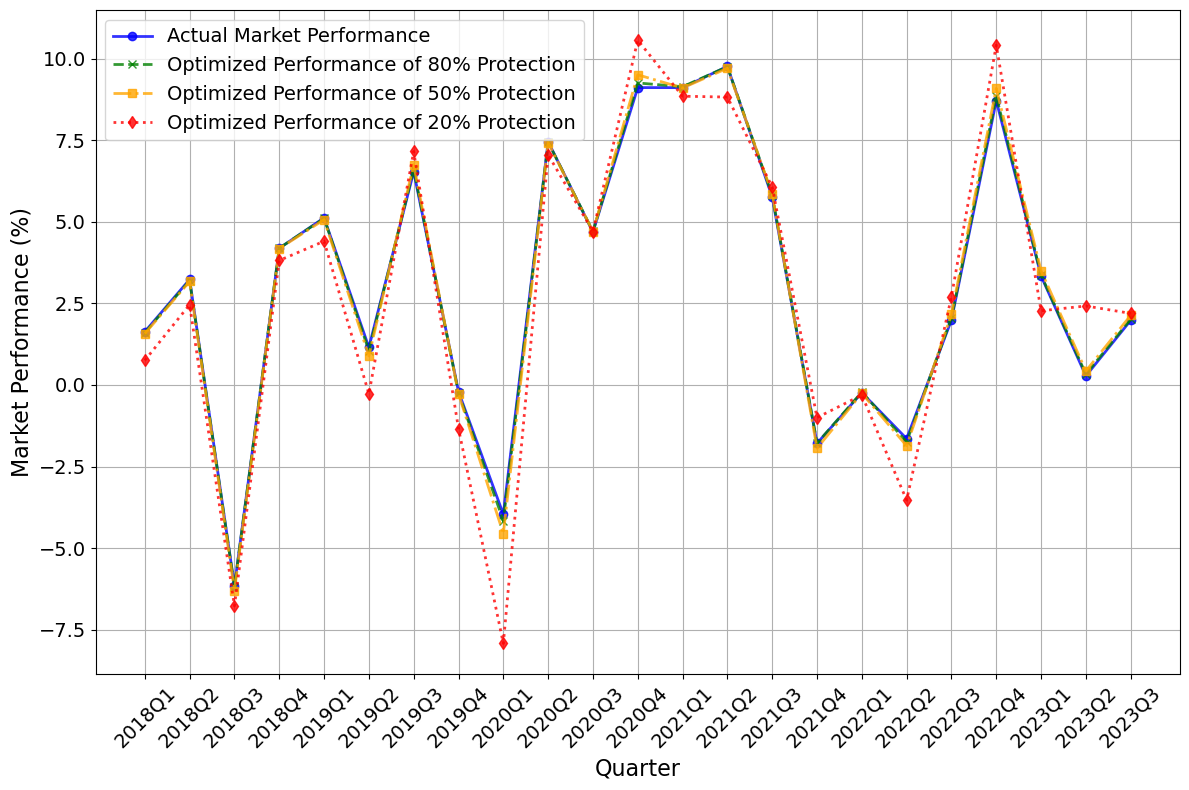

In [19]:
# Figure represents the optimised vs. actual market performance under 20%, 50%, and 80% protection
# Plotting with transparency and more distinct styles
plt.figure(figsize=(12, 8))

# Plot each line with distinct styles and transparency
plt.plot(results_80['Quarter'], results_80['ActualPerformance'], label='Actual Market Performance', color='blue', linewidth=2, marker='o', alpha=0.8)
plt.plot(results_80['Quarter'], results_80['OptimizedPerformance'], label='Optimized Performance of 80% Protection', color='green', linestyle='--', linewidth=2, marker='x', alpha=0.8)
plt.plot(results_50['Quarter'], results_50['OptimizedPerformance'], label='Optimized Performance of 50% Protection', color='orange', linestyle='-.', linewidth=2, marker='s', alpha=0.8)
plt.plot(results_20['Quarter'], results_20['OptimizedPerformance'], label='Optimized Performance of 20% Protection', color='red', linestyle=':', linewidth=2, marker='d', alpha=0.8)

# Set labels and title with increased font sizes
plt.xlabel('Quarter', fontsize=16)
plt.ylabel('Market Performance (%)', fontsize=16)
#plt.title('Optimized vs Actual Market Performance Across Different Protection Levels Over Time', fontsize=18)

# Increase tick label sizes
plt.tick_params(axis='both', which='major', labelsize=14)

# Show legend with increased font size
plt.legend(fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

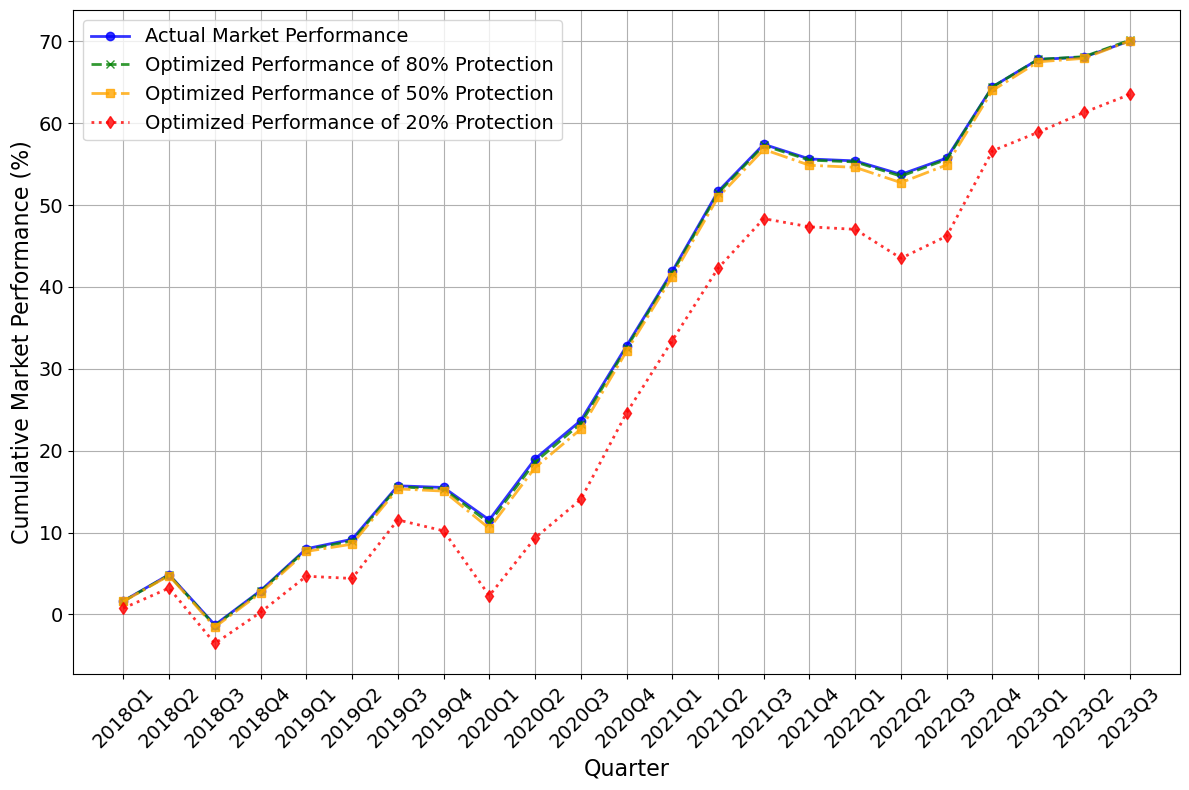

In [20]:
# Figure represents the optimised vs. actual cumulative market performance under 20%, 50%, and 80% protection
# Plotting with transparency and more distinct styles
plt.figure(figsize=(12, 8))

# Plot each line with distinct styles and transparency
plt.plot(results_80['Quarter'], results_80['CumulativeActualPerformance'], label='Actual Market Performance', color='blue', linewidth=2, marker='o', alpha=0.8)
plt.plot(results_80['Quarter'], results_80['CumulativeOptimizedPerformance'], label='Optimized Performance of 80% Protection', color='green', linestyle='--', linewidth=2, marker='x', alpha=0.8)
plt.plot(results_50['Quarter'], results_50['CumulativeOptimizedPerformance'], label='Optimized Performance of 50% Protection', color='orange', linestyle='-.', linewidth=2, marker='s', alpha=0.8)
plt.plot(results_20['Quarter'], results_20['CumulativeOptimizedPerformance'], label='Optimized Performance of 20% Protection', color='red', linestyle=':', linewidth=2, marker='d', alpha=0.8)

# Set labels and title with increased font sizes
plt.xlabel('Quarter', fontsize=16)
plt.ylabel('Cumulative Market Performance (%)', fontsize=16)
#plt.title('Cumulative Optimized vs Actual Market Performance Across Different Protection Levels Over Time', fontsize=18)

# Increase tick label sizes
plt.tick_params(axis='both', which='major', labelsize=14)

# Show legend with increased font size
plt.legend(fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()